# Customer to road network-assignment

In [1]:
%%html
<style>
table {float:left}
</style>

| Document info | |
| --- | --- | 
| Area of interest: | Singapore |
| Prepared by: | Waste Labs (wastelabs.co) |
| Prepared for: | Demonstration purposes |
| Contact: | info@wastelabs.co |

In [2]:
%reload_kedro
%load_ext autoreload
%autoreload 2
%config IPCompleter.use_jedi = False

import pandas as pd

# Extra options
# Extra options
pd.options.display.max_rows = 250
pd.options.display.max_columns = 250

# Show all code cells outputs
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import logging

logging.basicConfig(level=logging.INFO)

import importlib
import os
import sys

import geopandas as gpd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
from geopandas.tools import sjoin
from GPSOdyssey import Kepler
from IPython.display import clear_output
from ipywidgets import fixed, interact, interact_manual, interactive
from shapely import wkt

2022-06-02 16:24:15,436 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-06-02 16:24:15,503 - root - INFO - ** Kedro project Demand estimation and waste collection routing optimisation for the City of Cape Town
2022-06-02 16:24:15,504 - root - INFO - Defined global variable `context`, `session` and `catalog`
2022-06-02 16:24:15,513 - root - INFO - Registered line magic `run_viz`


In [3]:
from mcarptif.osmnx_network_extract.network_code_garp import (
    NetworkCode,
    create_gdf,
    create_latlon_gdf,
    customer_network_plot,
    return_crs,
)

## Get road network files

In [4]:
prep_network = catalog.load("road_network_simplified_24645_edges_xy_directed")
prep_network_plot = catalog.load("road_network_simplified_24645_edges_directed")

2022-06-02 16:24:21,706 - kedro.io.data_catalog - INFO - Loading data from `road_network_simplified_24645_edges_xy_directed` (GeoJSONDataSet)...
2022-06-02 16:24:22,827 - kedro.io.data_catalog - INFO - Loading data from `road_network_simplified_24645_edges_directed` (GeoJSONDataSet)...


## Get lat-lon files

In [5]:
producer_file = catalog.load("syn_pop_lat_lon_ids_20220601")
producer_file = create_latlon_gdf(producer_file)

2022-06-02 16:24:32,530 - kedro.io.data_catalog - INFO - Loading data from `syn_pop_lat_lon_ids_20220601` (CSVDataSet)...


<AxesSubplot:>

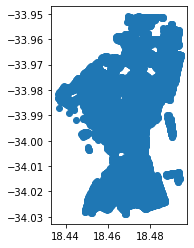

In [6]:
producer_file.plot()

In [7]:
%%time
df_producer_geo = producer_file.to_crs("EPSG:3414")

CPU times: user 658 ms, sys: 7.07 ms, total: 666 ms
Wall time: 681 ms


## Filter households in specific gap-zone

In [8]:
gap_zones = catalog.load("gap_zones").to_crs("EPSG:3414")
gap_zones_sample = gap_zones.loc[gap_zones["OBJECTID"].isin([24645])]
df_producer_geo_contained = gpd.tools.sjoin(df_producer_geo, gap_zones_sample, predicate="within")

2022-06-02 16:24:43,901 - kedro.io.data_catalog - INFO - Loading data from `gap_zones` (GeoJSONDataSet)...


In [9]:
df_producer_geo = df_producer_geo.loc[df_producer_geo["lat_lon_id"].isin(df_producer_geo_contained["lat_lon_id"])]
df_producer_geo.shape

(20681, 4)

### Customer locations

In [10]:
geocode_network = NetworkCode(prep_network, "SG", xy_converted=True)
geocode_network.set_arc_ids("arc_id", "geom_id_order")
geocode_network.convert_direct()

2022-06-02 16:24:49,424 - root - INFO - Convert network to x-y
2022-06-02 16:24:49,449 - root - INFO - Extracting nodes from network


/Users/ejwillemse/dev/waste_labs_dev/project_rdi_cpt/src/mcarptif/osmnx_network_extract/network_code_garp.py:65: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  df = gpd.GeoDataFrame(df, geometry=df['geometry'], crs=crs)


2022-06-02 16:24:49,851 - root - INFO - Removing opposing network arcs (only need one).
2022-06-02 16:24:49,870 - root - INFO - Arcs removed: 0.


In [11]:
geocode_network.add_customers(df_producer_geo)

2022-06-02 16:24:52,731 - root - INFO - Adding 20681 customers.


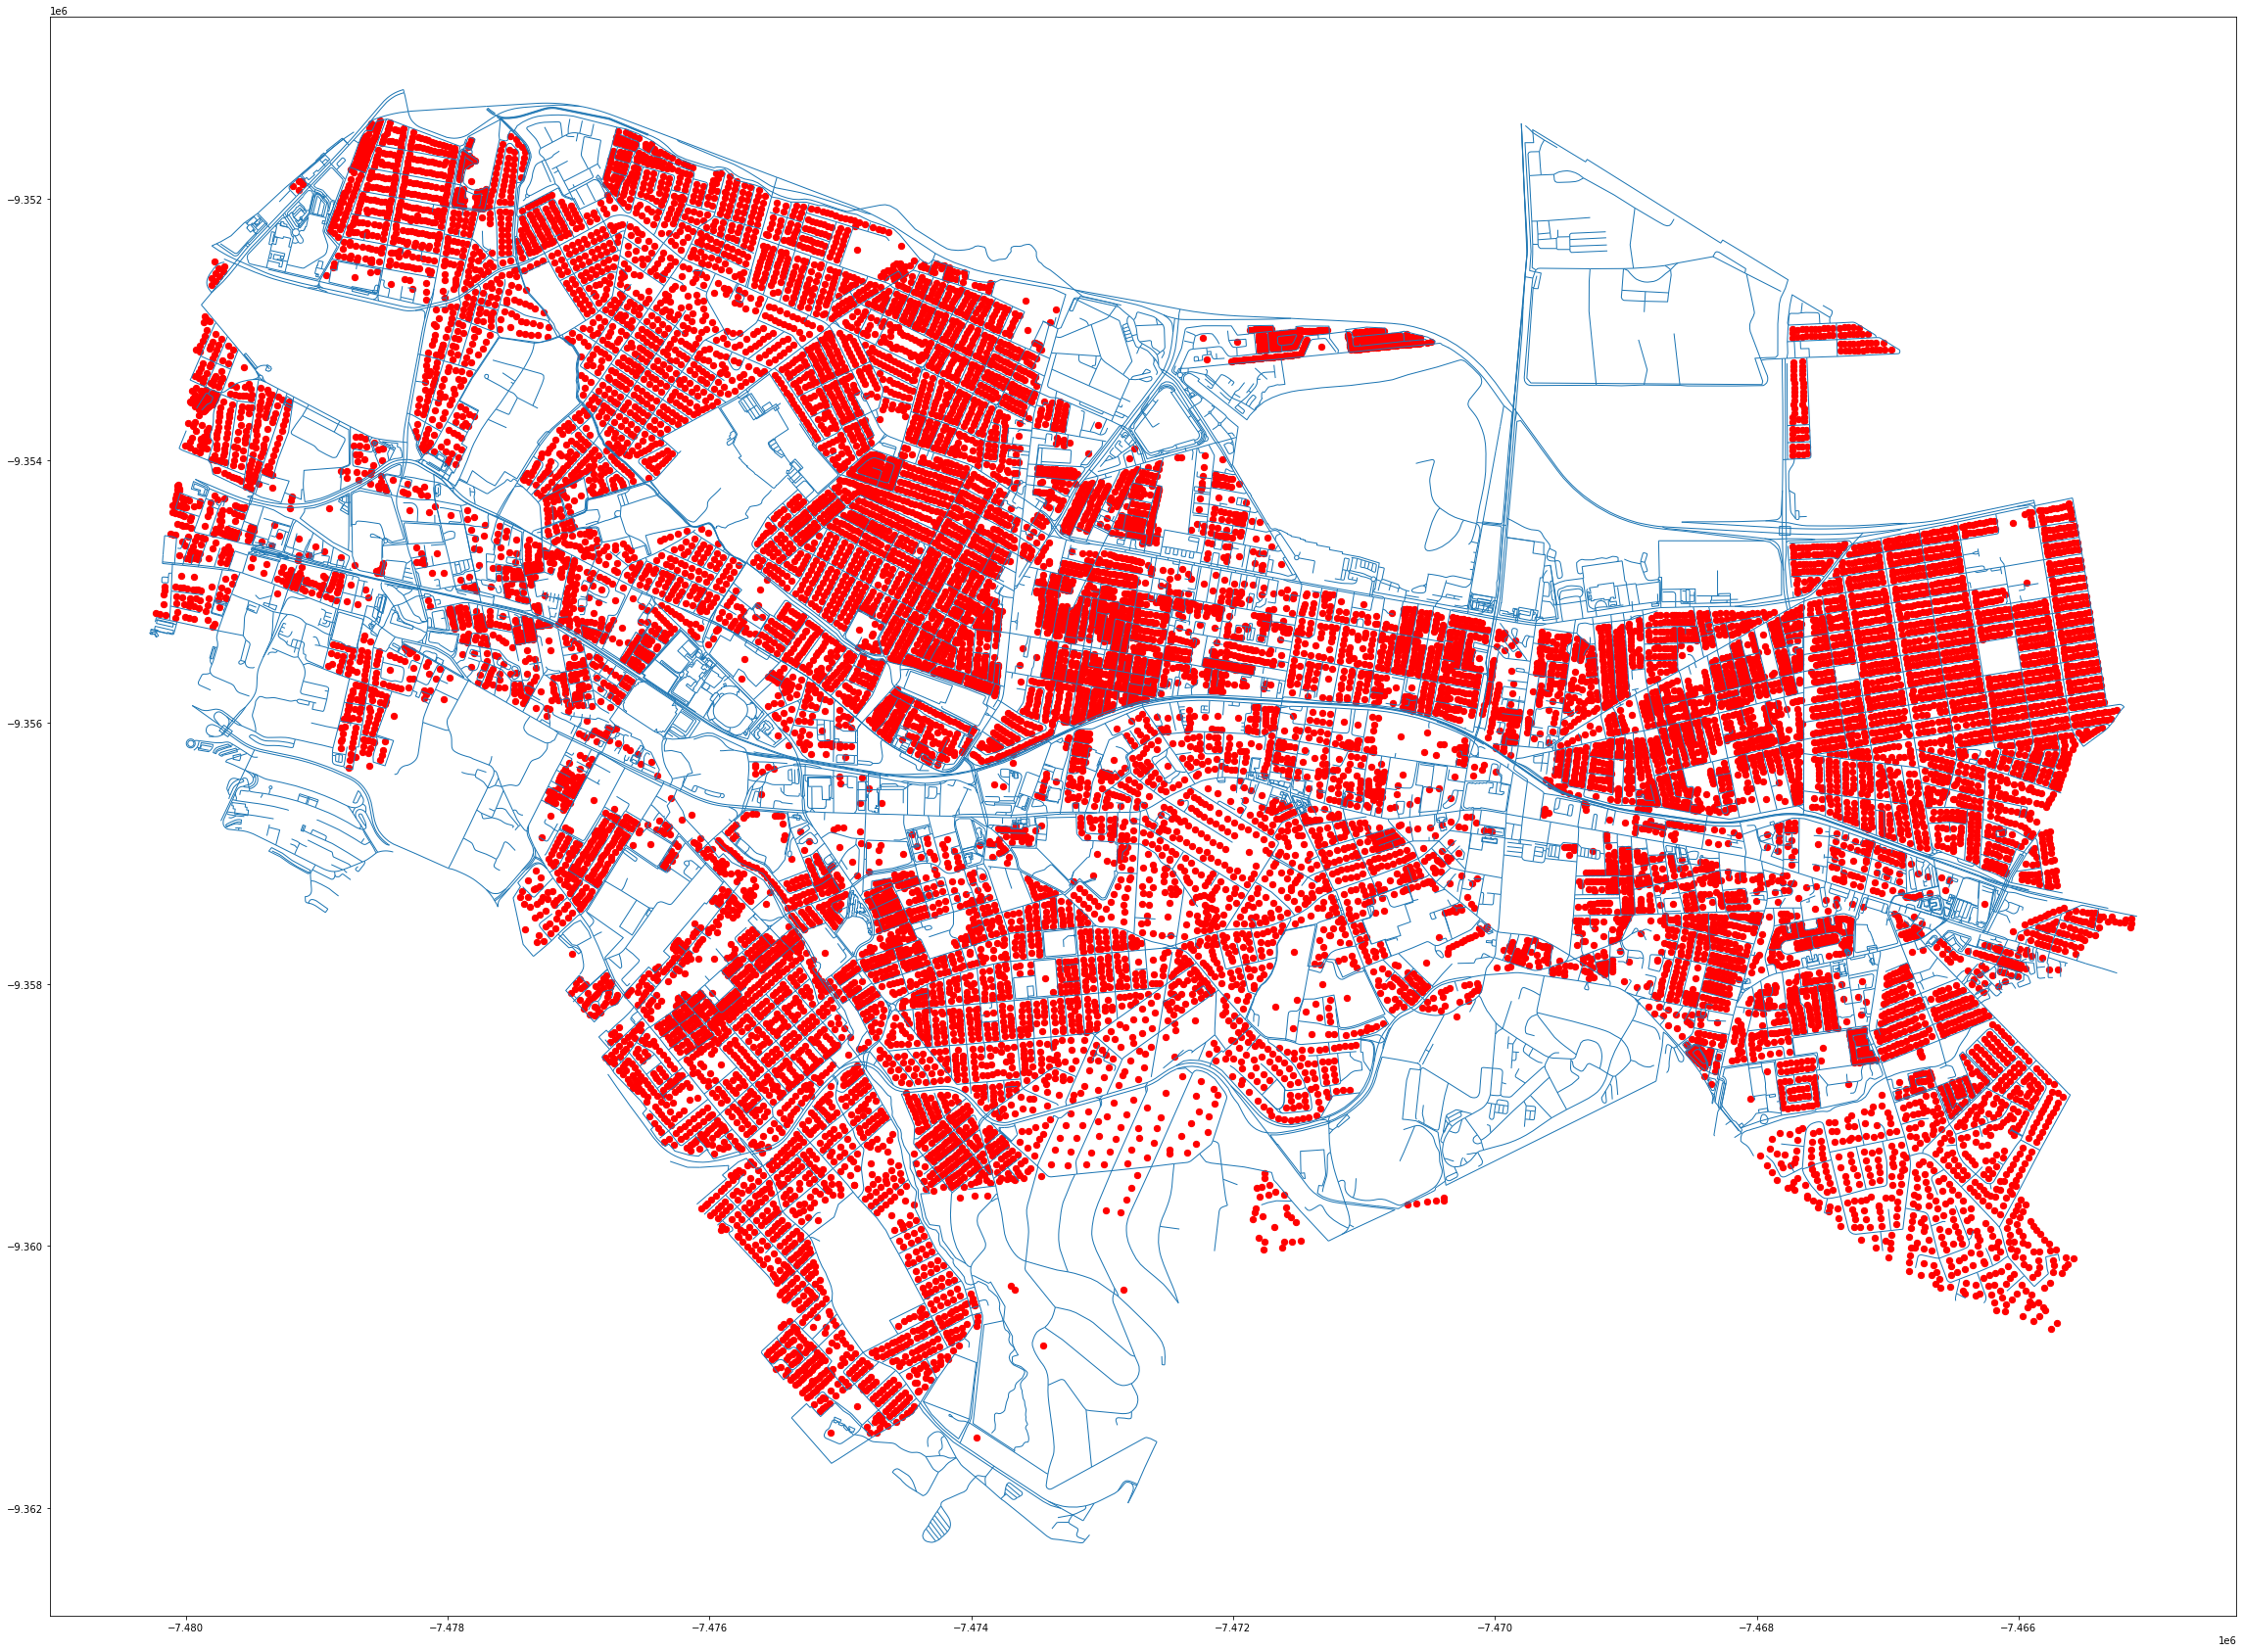

In [12]:
fig, ax = plt.subplots(figsize=(40, 40))
_ = geocode_network.df.plot(ax=ax, markersize=40, facecolor="red")
_ = geocode_network.df_network.plot(ax=ax, linewidth=1)

### Select road-types to use

In [13]:
prep_network["highway"] = prep_network["highway"].astype(str)
geocode_network.df_network["highway"] = geocode_network.df_network["highway"].astype(str)

In [14]:
road_select = list(prep_network["highway"].unique())
road_select.sort()
road_select.insert(0, "ALL")

multiple_prod_select = widgets.SelectMultiple(
    options=road_select,
    description="Road type:",
    #    value = ["['service', 'residential']",
    # 'service'],
    rows=20,
    disabled=False,
)


@interact
def filter_producers(descriptions=multiple_prod_select):
    global highway_select
    highway_select = descriptions
    if "ALL" not in highway_select:
        geocode_network.filter_network(
            filter_values=list(highway_select),
        )
    else:
        geocode_network.filter_network(
            filter_values=list(prep_network["highway"].unique())
        )
    geocode_network.df_network_filter = geocode_network.df_network_filter.set_index(
        ["u", "v", "key"]
    )

/Users/ejwillemse/opt/anaconda3/envs/python_RD/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py:11: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(SelectMultiple(description='Road type:', options=('ALL', 'None', 'living_street', 'motor…

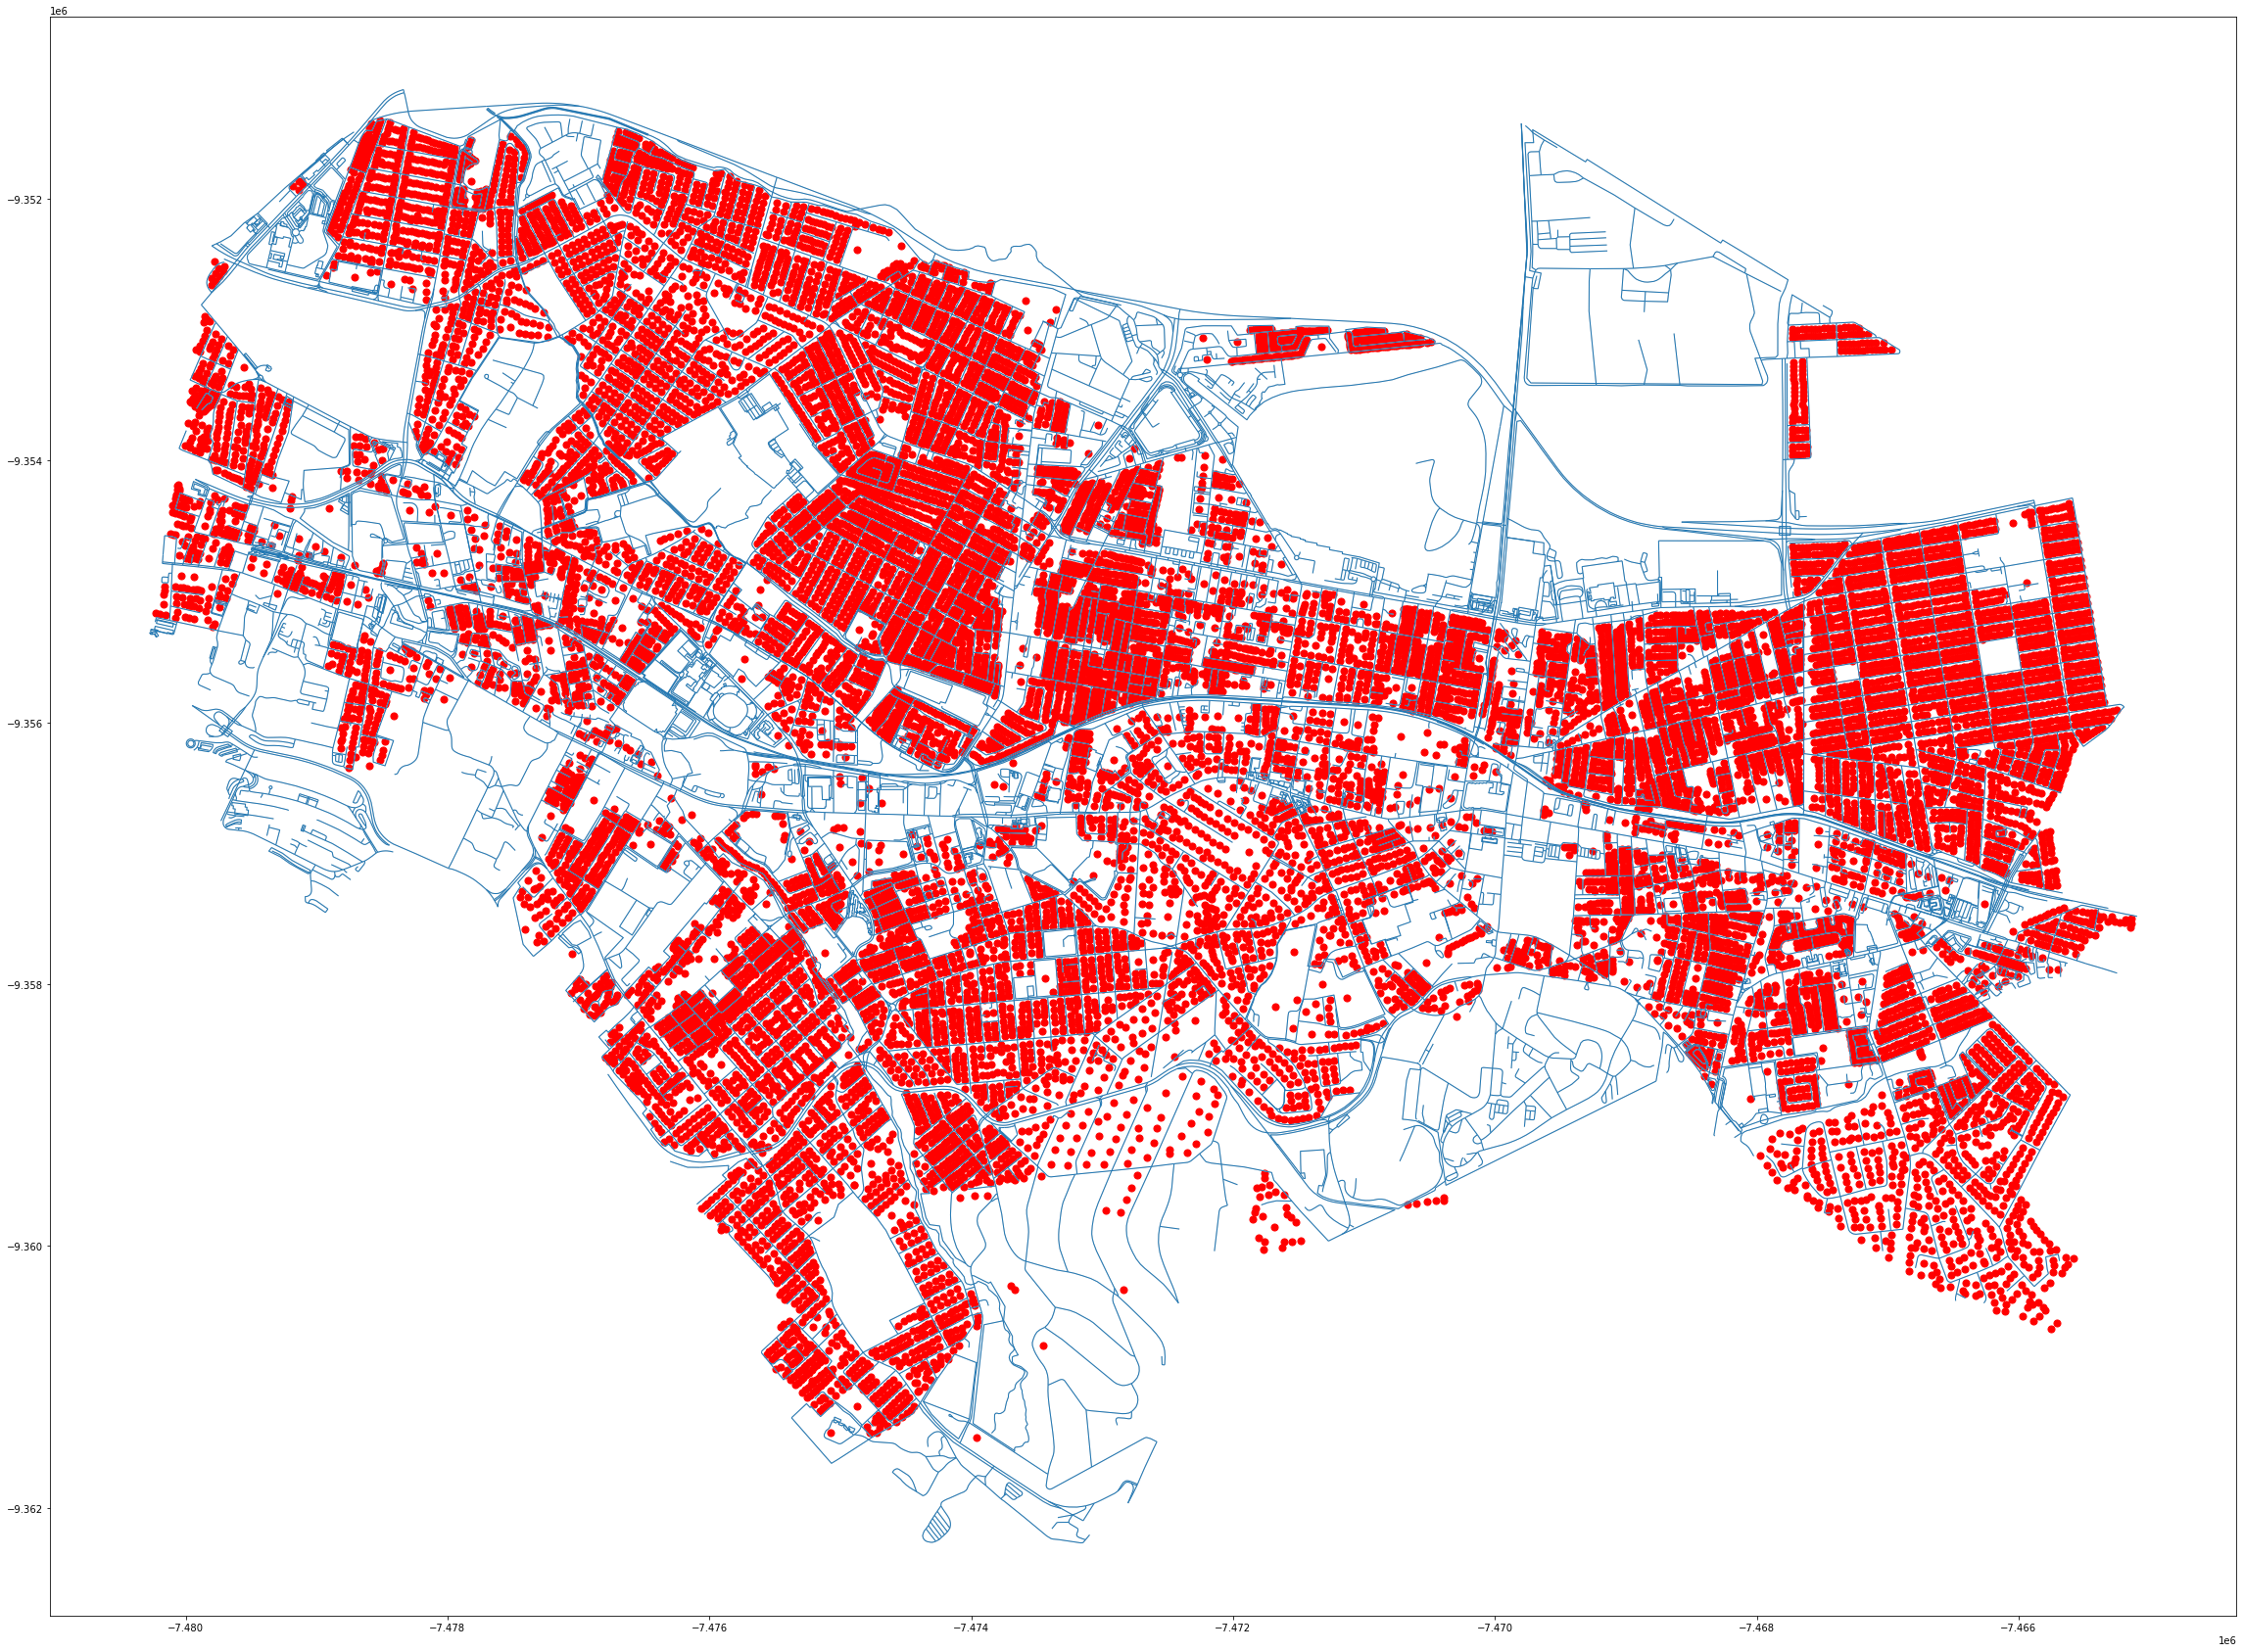

In [15]:
fig, ax = plt.subplots(figsize=(40, 40))
_ = geocode_network.df.plot(ax=ax, markersize=50, facecolor="red")
_ = geocode_network.df_network.plot(ax=ax, linewidth=1, color="lightgrey")
_ = geocode_network.df_network_filter.plot(ax=ax, linewidth=1)

In [17]:
%%time
geocode_network.find_nearest_collection_point()
geocode_network.merge_network()
geocode_network.convert_geometries_latlon()

2022-06-02 16:25:36,955 - root - INFO - Find nearest arc
2022-06-02 16:25:36,956 - root - INFO - Number of arcs 11173 number of points 20681


/Users/ejwillemse/opt/anaconda3/envs/python_RD/lib/python3.8/site-packages/osmnx/distance.py:455: UserWarning: The `get_nearest_edges` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_edges` instead.
  warnings.warn(msg)


2022-06-02 16:25:41,136 - root - INFO - Find closest assigned end point
2022-06-02 16:25:41,948 - root - INFO - Find closest point on assigned arc
2022-06-02 16:25:54,640 - root - INFO - Find best collection point
2022-06-02 16:25:54,682 - root - INFO - Adding arc attributes.
2022-06-02 16:25:54,702 - root - INFO - Convert geometries to lat-lon
CPU times: user 20.4 s, sys: 109 ms, total: 20.5 s
Wall time: 20.6 s


In [18]:
df_customer_fit = geocode_network.df_collection_points
plt_map = df_customer_fit[
    [
        "lon",
        "lat",
        "lon_collect",
        "lat_collect",
        "dist_collect",
        "arc_collect",
        "highway",
        "arc_id",
        "oneway",
    ]
].copy()
plt_map = plt_map.fillna("")
kep_map = Kepler(
    data={"customer_fit": plt_map, "road_network": prep_network_plot},
    height=1000,
    config_path="config/household_road_link_lat_lon_match_20220601.json",
)

2022-06-02 16:26:04,636 - root - INFO - Start preparation of render parameters...
2022-06-02 16:26:04,637 - root - INFO - Loading map config from file: config/household_road_link_lat_lon_match.json
2022-06-02 16:26:04,645 - root - INFO - Next columns are converted to string: ['arc_id', 'highway', 'oneway']
2022-06-02 16:26:04,694 - root - INFO - Next columns are converted to string: ['service', 'geom_id', 'bridge', 'ref', 'name', 'arc_id', 'width', 'maxspeed', 'access', 'osmid', 'junction', 'landuse', 'tunnel', 'geom_id_order', 'highway', 'geom_id_inv', 'oneway', 'lanes']
2022-06-02 16:26:04,695 - root - INFO - Start renderding KeplerGL map...
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [19]:
m = kep_map.get_render()
m

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'n5f3efa', 'type': …

In [20]:
kep_map.save_config(path="config/household_road_link_lat_lon_match_20220601.json", overwrite_config=True)

In [21]:
kep_map.save_render(path="config/household_road_link_lat_lon_match_20220601.html", overwrite_html=True)

2022-06-02 16:26:33,228 - root - INFO - Next columns are converted to string: ['arc_id', 'highway', 'oneway']
2022-06-02 16:26:33,274 - root - INFO - Next columns are converted to string: ['service', 'geom_id', 'bridge', 'ref', 'name', 'arc_id', 'width', 'maxspeed', 'access', 'osmid', 'junction', 'landuse', 'tunnel', 'geom_id_order', 'highway', 'geom_id_inv', 'oneway', 'lanes']
Map saved to config/household_road_link_lat_lon_match_20220601.html!


### Save scenario

In [22]:
%reload_kedro
catalog.save("lat_lon_key_network_match_20220601", geocode_network.df_collection_points)

2022-06-02 16:26:35,592 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-06-02 16:26:35,685 - root - INFO - ** Kedro project Demand estimation and waste collection routing optimisation for the City of Cape Town
2022-06-02 16:26:35,686 - root - INFO - Defined global variable `context`, `session` and `catalog`
2022-06-02 16:26:35,696 - root - INFO - Registered line magic `run_viz`
2022-06-02 16:26:35,697 - kedro.io.data_catalog - INFO - Saving data to `lat_lon_key_network_match_20220601` (CSVDataSet)...
